In [2]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt

import os as os

import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pltbook import plot_contour_row, container, setup_map


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def add_fhour(ds):

        filename = ds.encoding["source"].split("_")

        init_time = int(filename[-2])
        fhour     = int(filename[-1][-5:-3])

        ds.coords['fhour'] = fhour
        ds.coords['init_time'] = init_time

        return ds
    
def open_mfdataset_list(run_dir, pattern, model_type):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
    filelist = os.path.join(run_dir,pattern)
    return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)

def read_wrf(run_dir, pattern, model_type):
        
    #ds   = open_mfdataset_list(run_dir, pattern, model_type)
    
    ds   = xr.open_dataset(os.path.join(run_dir,pattern))


    if model_type == 'mpas':
        
        data = {
                'w':   ds.w.values,
                'u':   ds.u.values,
                'v':   ds.v.values,
                't':  ds.theta.values,
                'qv':  1000*ds.qv.values,
                'ref': ds.refl10cm.values,
               }
       
    if model_type == 'mpas2':
        
        data = {
                'w':   ds.w.values,
                'u':   ds.uReconstructZonal.values,
                'v':   ds.uReconstructMeridional.values,
                't':   ds.theta.values,
                'qv':  1000*ds.qv.values,
              #  'ref': ds.refl10cm.values,
                'lats': ds.lat.values,
                'lons': ds.lon.values,
               }
        
    if model_type == 'wrf':
        
        data = {
                'w': 0.5*(ds.W.values[:,1:,:,:] + ds.W.values[:,:-1,:,:]),
                'u': 0.5*(ds.U.values[:,:,:,1:] + ds.U.values[:,:,:,:-1]),
                'v': 0.5*(ds.V.values[:,:,1:,:] + ds.V.values[:,:,:-1,:]),
                't': ds.T.values,
                'hd': ds.H_DIABATIC.values,
                'qv':  1000*ds.QVAPOR.values,
                'ref': ds.REFL_10CM.values,
                'lats': ds.XLAT.values,
                'lons': ds.XLONG.values,
               }
    ds.close()
    
    return data
    

In [11]:
# open files

mpas  = read_wrf('/work/wicker/MPAS_WRF_comp/mpas/run_dirs/20240508/1900/benchmark_quad', 'wofs_gsl_01.history.2024-05-08_20.00.00_quad.nc', 'mpas2')

mpasb = read_wrf('/work/wicker/MPAS_WRF_comp/mpas/run_dirs/20240508/1900/wofuser_bench', 'wofs_gsl_01.history.2024-05-08_20.00.00_quad.nc', 'mpas2')


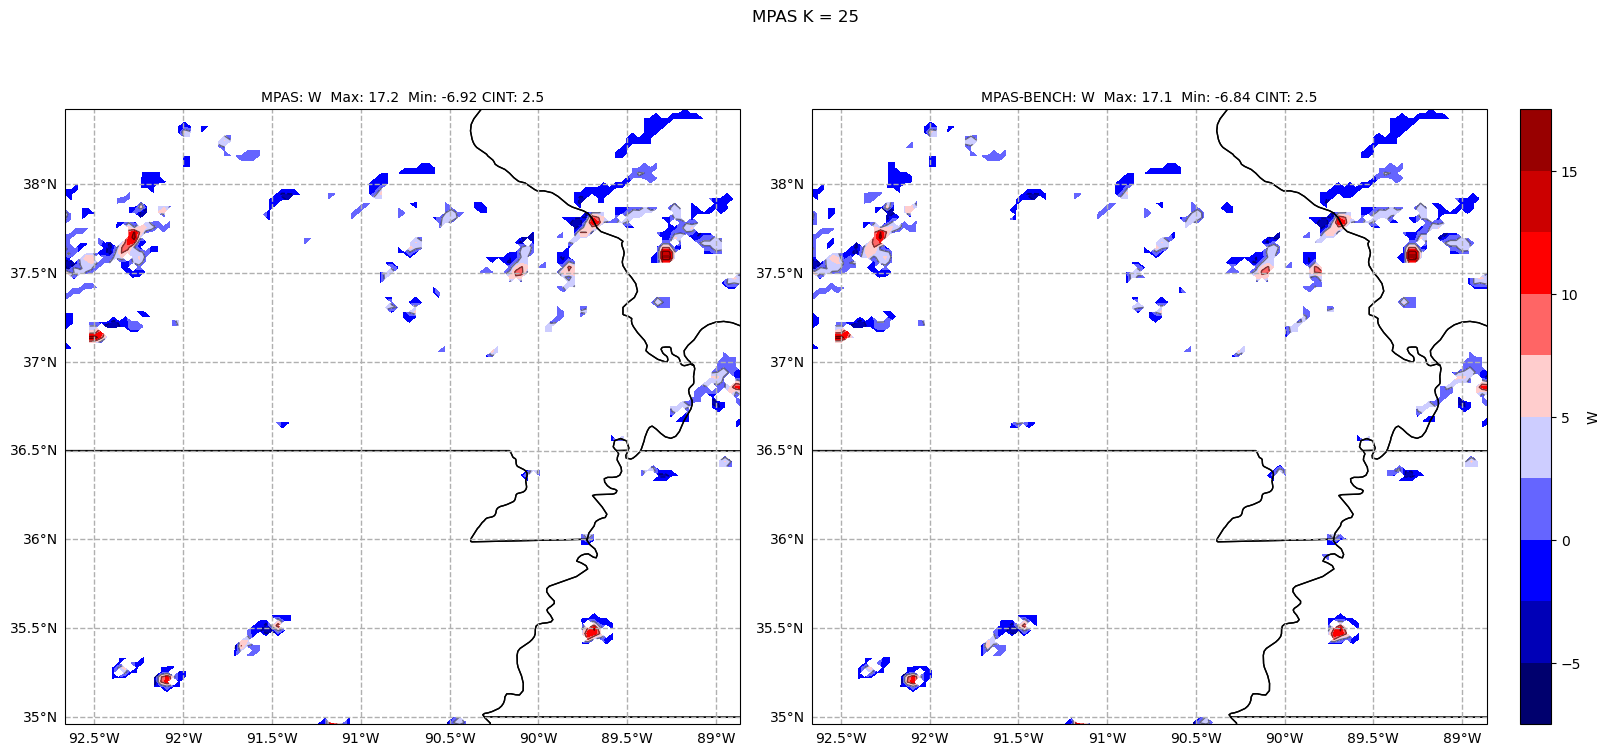

In [29]:
# basic plot

extent = [mpas['lons'].min()+3.0,mpas['lons'].max()-4.0,mpas['lats'].min()+3,mpas['lats'].max()-2]

vars    = ['w',]
cints   = [2.5,]
climits = [[-1.0,1.0],]
fmasks  = [0.25,]
klevels = [25, ]

for var, cint, climit, klevel in zip(vars, cints, climits, klevels):
    
    fig, ax = setup_map(2, extent=extent, draw_gridlines=True, figsize=[16,8])

    model = container(mpas[var][0,klevel,:,:], mpas['lons'][:,:], mpas['lats'][:,:], mask_in=climit)

    modelb = container(mpasb[var][0,klevel,:,:], mpasb['lons'][:,:], mpasb['lats'][:,:], mask_in=climit)
 
    plot_contour_row([model, modelb], ptype=0, ptitle=['MPAS', 'MPAS-BENCH'], suptitle='MPAS K = %2.2i' %(klevel), var=var.upper(),
                     xlabel='X (km)', ylabel='Y (km)', cint=cint, ax_in=ax, cmap='seismic', transform=ccrs.PlateCarree());

    #plt.savefig("/work/wicker/MPAS_Diagnostic_Tools/DA_tests/plots/Single_ob_%s_K%2.2i.png" % (var, klevel))

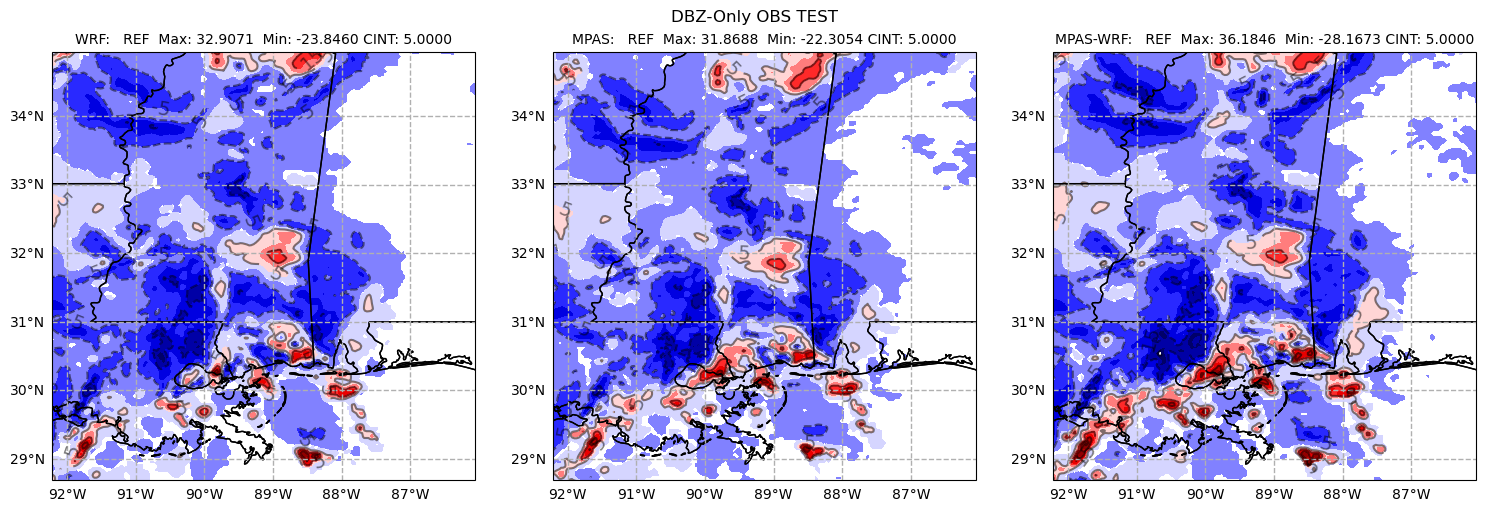

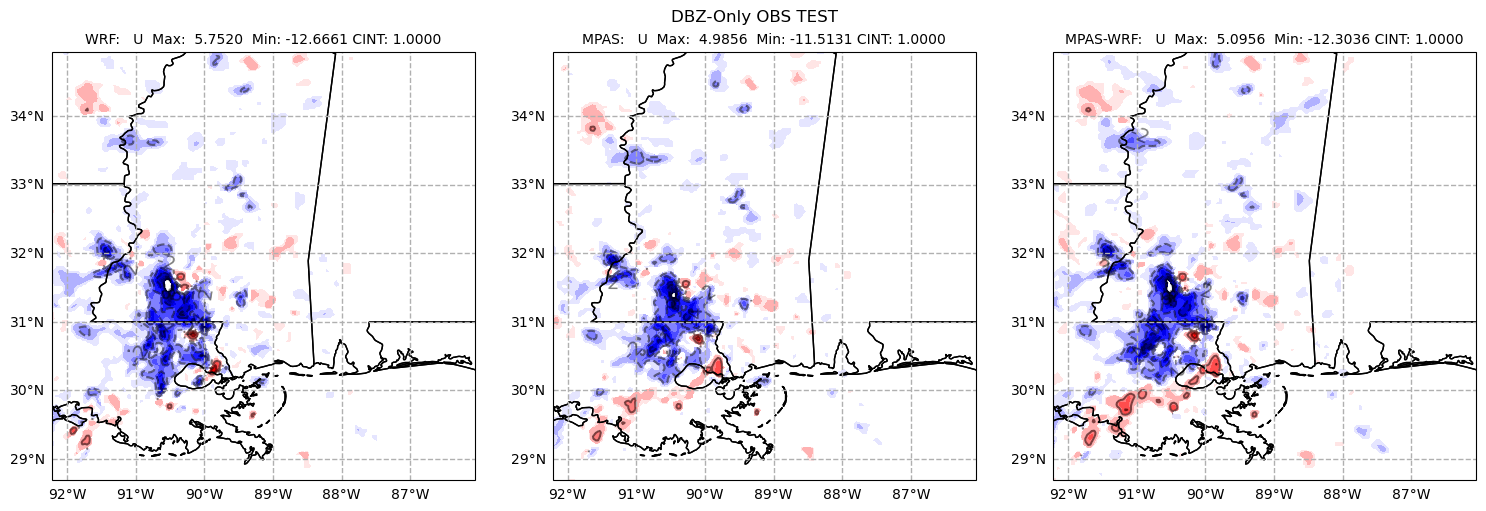

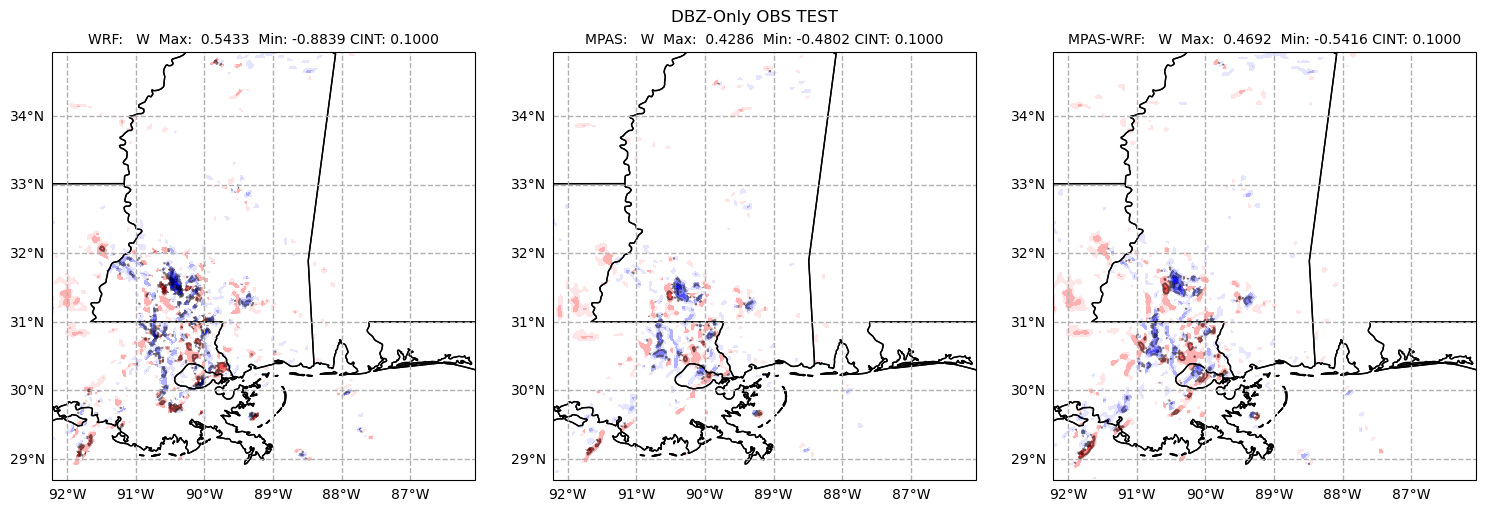

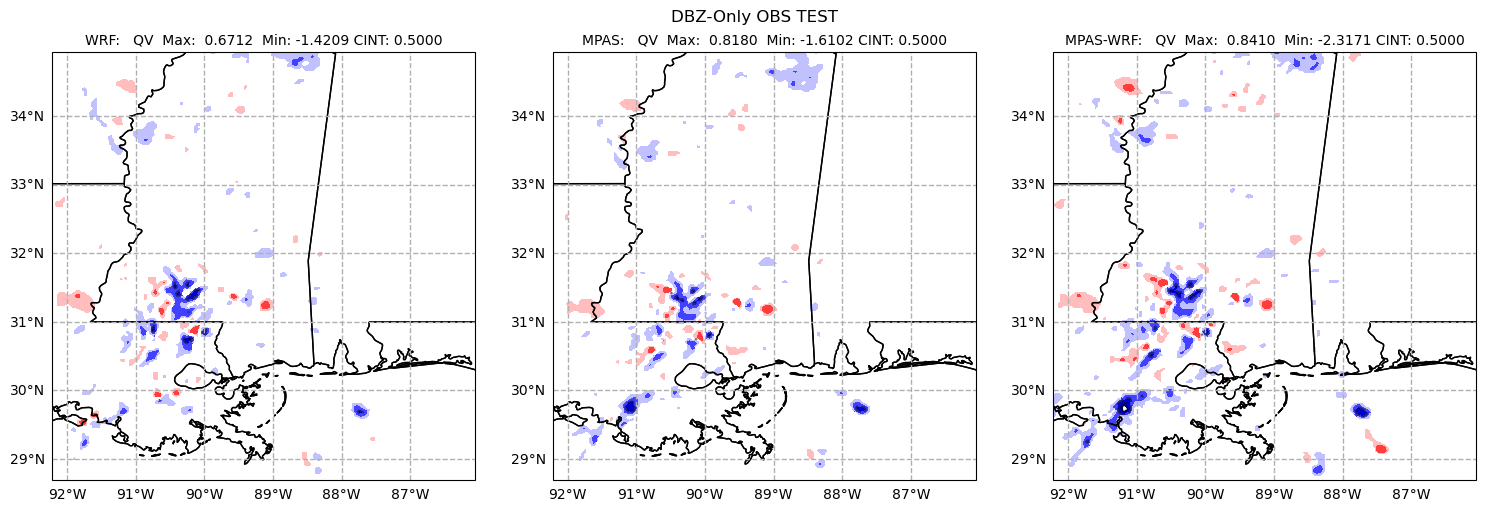

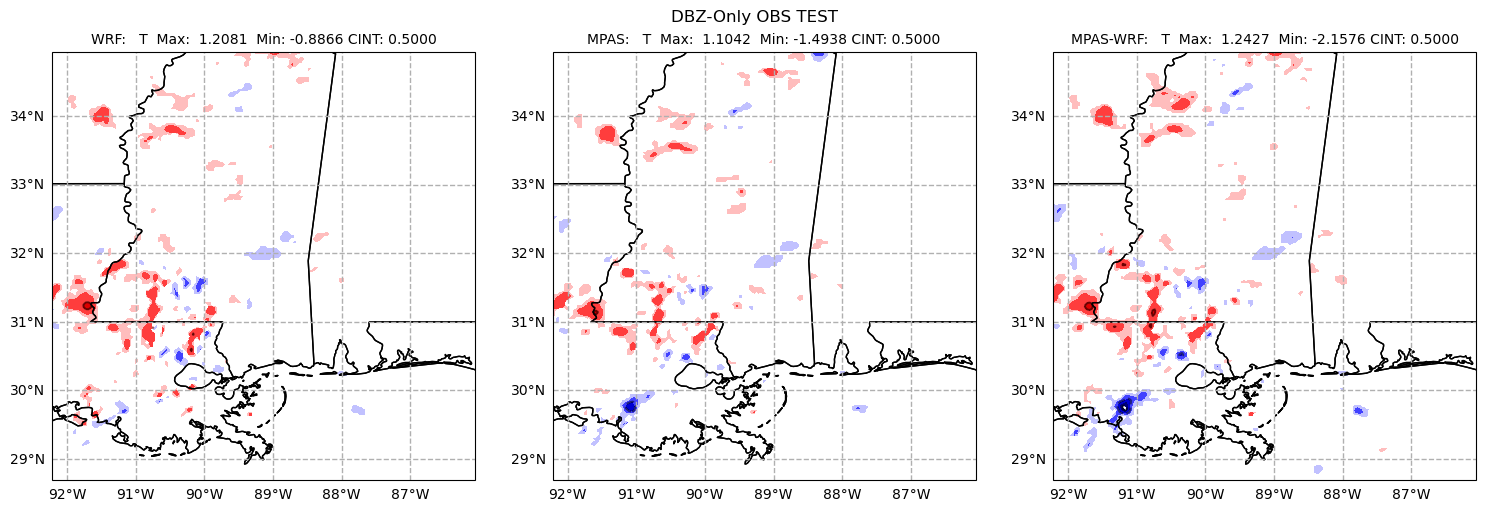

In [20]:
# DBZ only

mpas    = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/DA_tests', 'mpas_diff_mean_dbz.nc', 'mpas')
mpaswrf = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/DA_tests', 'mpaswrf_mean_diff_dbz.nc', 'wrf')
wrf     = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/DA_tests', 'wrf_mean_diff_dbz.nc', 'wrf')

extent = [mpaswrf['lons'].min()+2.0,mpaswrf['lons'].max()-2.0,mpaswrf['lats'].min()+1,mpaswrf['lats'].max()-1]

vars    = ['ref', 'u', 'w', 'qv', 't']
cints   = [5, 1, 0.1, 0.5, 0.5]
climits = [[-25, 35], [-10,10], [-1,1], [-2,2], [-2,2]]
fmasks  = [0.1, 0.5, 0.05, 0.25, 0.25]


for var, cint, climit, fmask in zip(vars, cints, climits, fmasks):
    
    fig, ax = setup_map(3, extent=extent, draw_gridlines=True)

    klevel = 10

    model2 = container(mpas[var][0,klevel,:,:], mpaswrf['lons'][:,:], mpaswrf['lats'][:,:])
 
    model3 = container(mpaswrf[var][0,klevel,:,:], mpaswrf['lons'][:,:], mpaswrf['lats'][:,:])

    model1 = container(wrf[var][0,klevel,:,:], mpaswrf['lons'][:,:], mpaswrf['lats'][:,:])

    plot_contour_row([model1, model2, model3], levels=0, ptitle=['WRF', 'MPAS', 'MPAS-WRF'], suptitle='DBZ-Only OBS TEST', var=var.upper(),
                     xlabel='X (km)', ylabel='Y (km)', cint=cint, climits=climit, fmask=fmask, ax_in=ax, cmap='seismic', transform=ccrs.PlateCarree());

    plt.savefig("/work/wicker/MPAS_Diagnostic_Tools/DA_tests/plots/DBZ_ONLY_%s_K%2.2i.png" % (var, klevel))

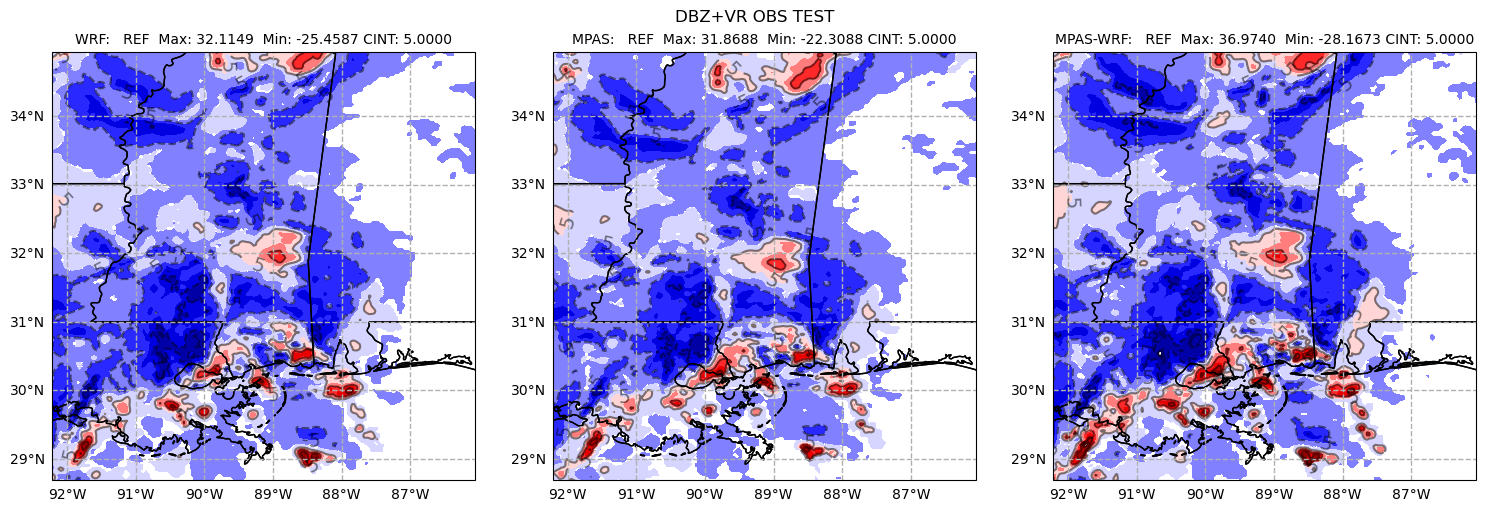

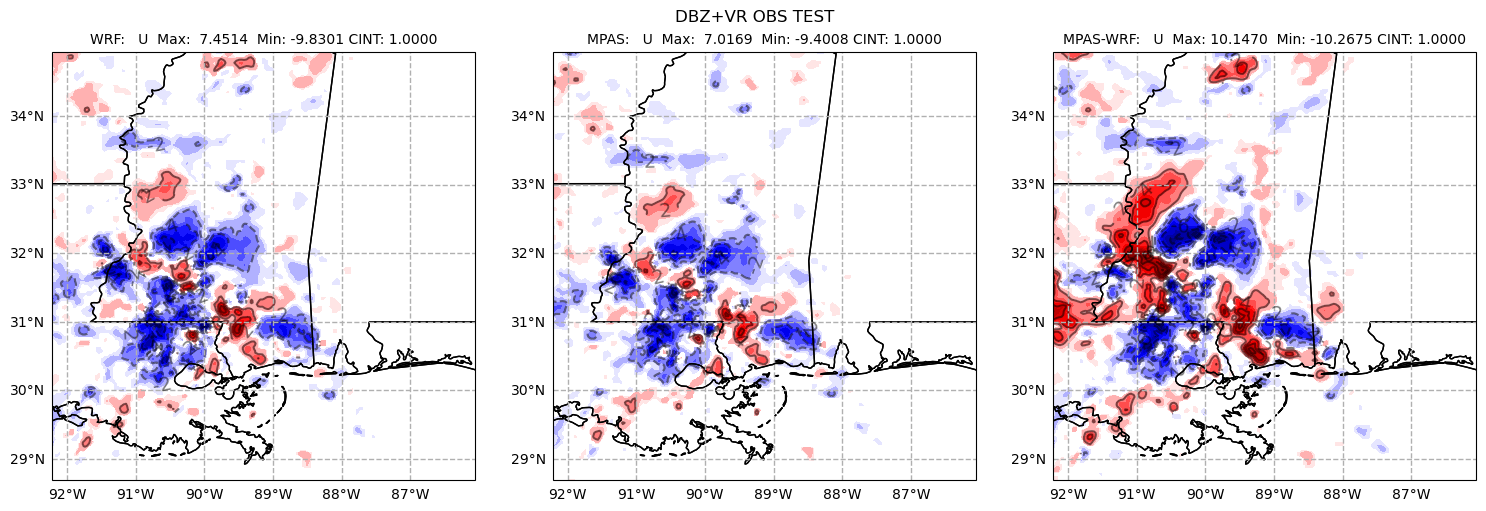

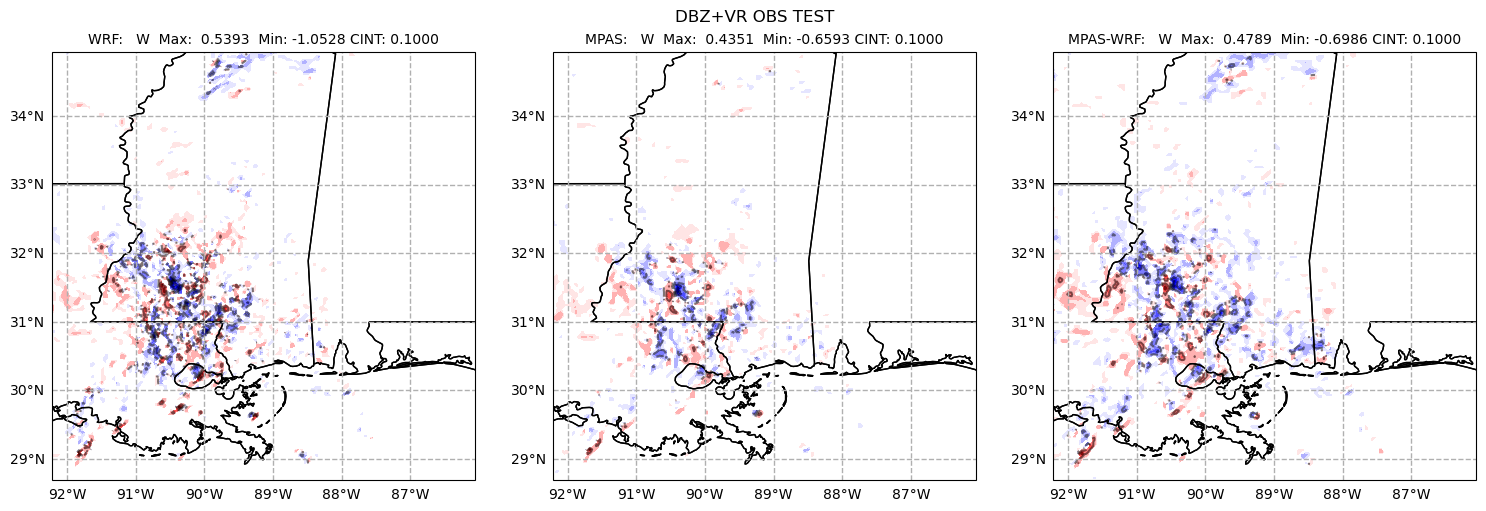

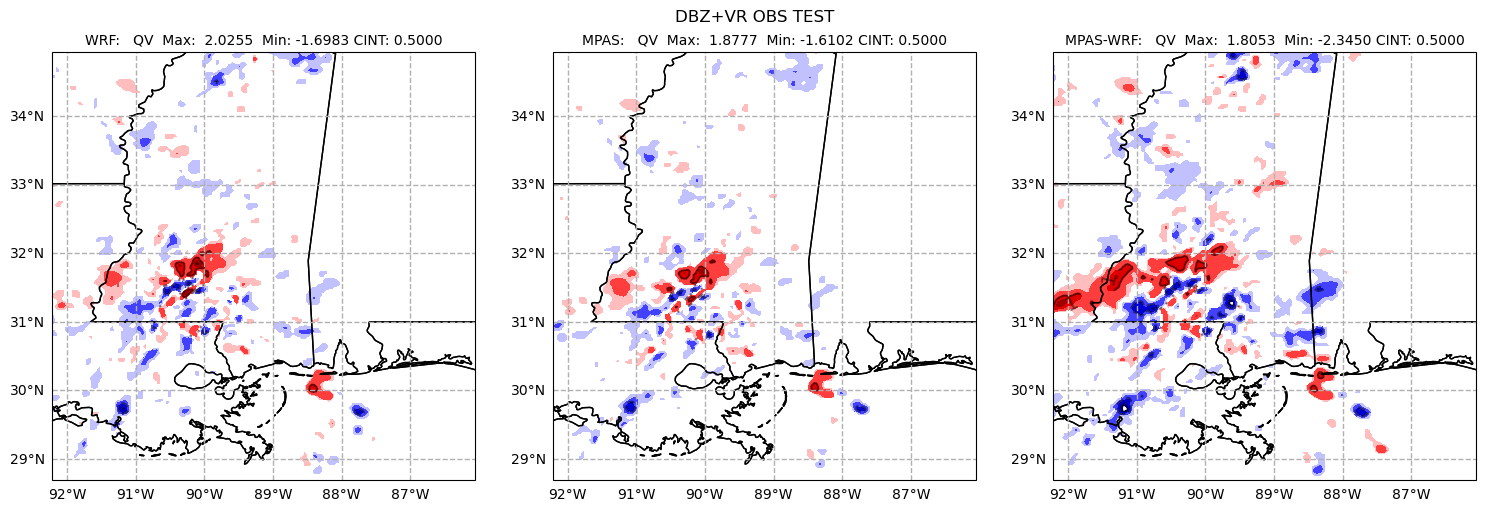

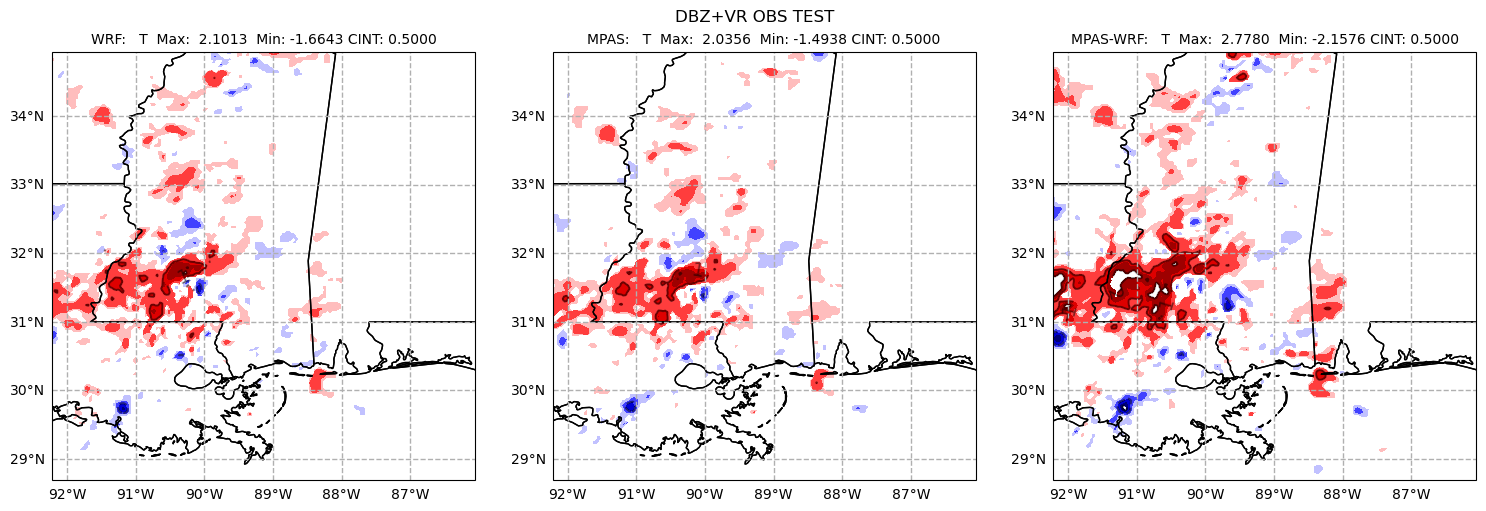

In [21]:
# DBZ+VR only

mpas    = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/DA_tests', 'mpas_diff_mean_dbzvr.nc', 'mpas')
mpaswrf = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/DA_tests', 'mpaswrf_mean_diff_dbzvr.nc', 'wrf')
wrf     = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/DA_tests', 'wrf_mean_diff_dbzvr.nc', 'wrf')

extent = [mpaswrf['lons'].min()+2.0,mpaswrf['lons'].max()-2.0,mpaswrf['lats'].min()+1,mpaswrf['lats'].max()-1]

vars    = ['ref', 'u', 'w', 'qv', 't']
cints   = [5, 1, 0.1, 0.5, 0.5]
climits = [[-25, 35], [-10,10], [-1,1], [-2,2], [-2,2]]
fmasks  = [0.1, 0.5, 0.05, 0.25, 0.25]


for var, cint, climit, fmask in zip(vars, cints, climits, fmasks):
    
    fig, ax = setup_map(3, extent=extent, draw_gridlines=True)

    klevel = 10

    model2 = container(mpas[var][0,klevel,:,:], mpaswrf['lons'][:,:], mpaswrf['lats'][:,:])
 
    model3 = container(mpaswrf[var][0,klevel,:,:], mpaswrf['lons'][:,:], mpaswrf['lats'][:,:])

    model1 = container(wrf[var][0,klevel,:,:], mpaswrf['lons'][:,:], mpaswrf['lats'][:,:])

    plot_contour_row([model1, model2, model3], levels=0, ptitle=['WRF', 'MPAS', 'MPAS-WRF'], suptitle='DBZ+VR OBS TEST', var=var.upper(),
                     xlabel='X (km)', ylabel='Y (km)', cint=cint, climits=climit, fmask=fmask, ax_in=ax, cmap='seismic', transform=ccrs.PlateCarree());

    plt.savefig("/work/wicker/MPAS_Diagnostic_Tools/DA_tests/plots/DBZ_VR_%s_K%2.2i.png" % (var, klevel))

(300, 300)


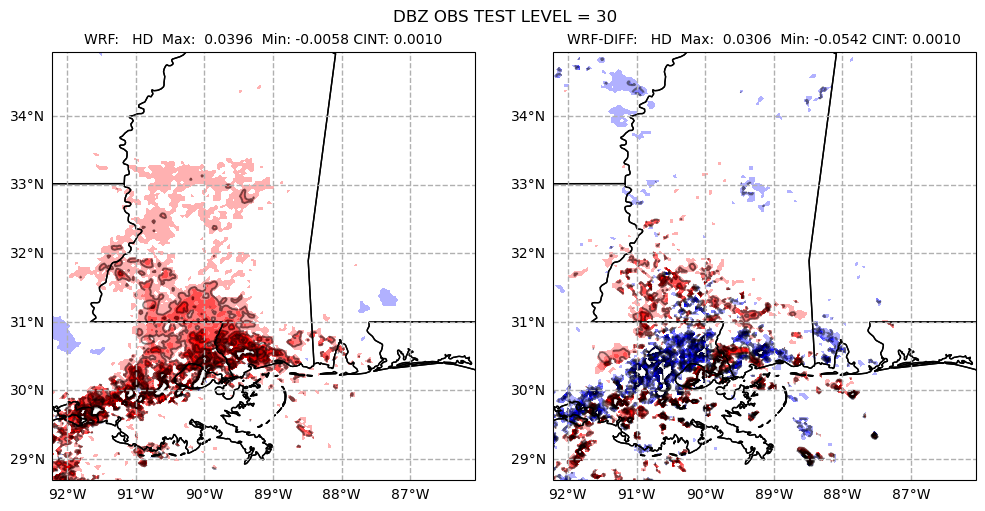

In [51]:
#Plot H-DIABATIC

wrf     = read_wrf('/scratch/tajones/dart/20240410/DBZ_ONLY/202404101515', 'preassim_mean.nc.202404101515', 'wrf')
wrfdiff = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/DA_tests', 'wrf_mean_diff_dbz.nc', 'wrf')

extent = [wrf['lons'].min()+2.0,wrf['lons'].max()-2.0,wrf['lats'].min()+1,wrf['lats'].max()-1]

vars    = ['hd']
cints   = [0.001]
climits = [[-0.01,0.01]]
fmasks  = [0.001]

for var, cint, climit, fmask in zip(vars, cints, climits, fmasks):
    
    fig, ax = setup_map(2, extent=extent, draw_gridlines=True)

    klevel = 30


    model2 = container(wrfdiff[var][0,klevel,:,:], wrfdiff['lons'][:,:], wrfdiff['lats'][:,:])
 
    model1 = container(wrf[var][0,klevel,:,:], wrf['lons'][:,:], wrf['lats'][:,:])

    plot_contour_row([model1, model2], levels=0, ptitle=['WRF', 'WRF-DIFF'], suptitle='DBZ OBS TEST LEVEL = %02i' % klevel, var=var.upper(),
                     xlabel='X (km)', ylabel='Y (km)', cint=cint, climits=climit, fmask=fmask, ax_in=ax, cmap='seismic', transform=ccrs.PlateCarree());

    plt.savefig("/work/wicker/MPAS_Diagnostic_Tools/DA_tests/plots/DBZ_HDIABATIC_%s_K%2.2i.png" % (var, klevel))

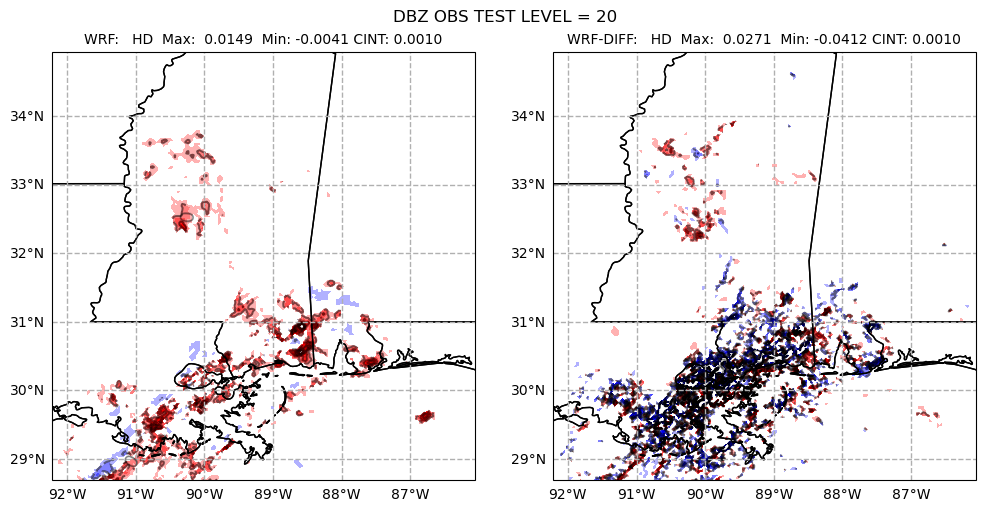

In [26]:
#Plot H-DIABATIC

wrf     = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/20240410/wrf', 'preassim_mean.202404101700.nc', 'wrf')
wrfdiff = read_wrf('/work/wicker/MPAS_Diagnostic_Tools/20240410/wrf', 'wrf_diff_01.nc', 'wrf')

extent = [wrf['lons'].min()+2.0,wrf['lons'].max()-2.0,wrf['lats'].min()+1,wrf['lats'].max()-1]

vars    = ['hd']
cints   = [0.001]
climits = [[-0.01,0.01]]
fmasks  = [0.001]

for var, cint, climit, fmask in zip(vars, cints, climits, fmasks):
    
    fig, ax = setup_map(2, extent=extent, draw_gridlines=True)

    klevel = 20

    model2 = container(wrfdiff[var][0,klevel,:,:], wrf['lons'][:,:], wrf['lats'][:,:])
 
    model1 = container(wrf[var][0,klevel,:,:], wrf['lons'][:,:], wrf['lats'][:,:])

    plot_contour_row([model1, model2], levels=0, ptitle=['WRF', 'WRF-DIFF'], suptitle='DBZ OBS TEST LEVEL = %02i' % klevel, var=var.upper(),
                     xlabel='X (km)', ylabel='Y (km)', cint=cint, climits=climit, fmask=fmask, ax_in=ax, cmap='seismic', transform=ccrs.PlateCarree());

    plt.savefig("/work/wicker/MPAS_Diagnostic_Tools/DA_tests/plots/DBZ_HDIABATIC_1700_%s_K%2.2i.png" % (var, klevel))

ref 5.0 [-10, 70] 10.0
<class 'cartopy.mpl.geoaxes.GeoAxes'>
<class 'cartopy.mpl.geoaxes.GeoAxes'>


TypeError: 'GeoAxes' object is not subscriptable

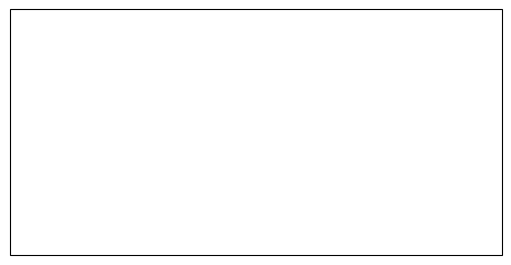

In [71]:
#Plot H-DIABATIC
import copy
from metpy.plots import ctables
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable


# normc = mcolors.Normalize(cmin,cmax)
# print(normc)

wrf     = read_wrf('/scratch/tajones/dart/20240410/DBZ_ONLY/202404101515', 'wrfinput_d01.1', 'wrf')
wrfdiff = read_wrf('/scratch/tajones/dart/20240410/DBZ_ONLY/202404101500', 'wrffcst_d01_2024-04-10_15:15:00_1', 'wrf')

extent = [wrfdiff['lons'].min()+2.0,wrfdiff['lons'].max()-2.0,wrfdiff['lats'].min()+1,wrfdiff['lats'].max()-1]

vars    = ['ref']
cints   = [5.]
climits = [[-10, 70]]
fmasks  = [10.]

# fig, ax = setup_map(2, extent=extent, draw_gridlines=True)
# klevel = 10

# # model2 = container(wrfdiff[var][0,klevel,:,:], wrfdiff['lons'][0,:,:], wrfdiff['lats'][0,:,:])
 
# # model1 = container(wrf[var][0,klevel,:,:], wrfdiff['lons'][0,:,:], wrfdiff['lats'][0,:,:])

# var='ref'

# cbar0 = ax[0].contourf(wrfdiff['lons'][0,:,:], wrfdiff['lats'][0,:,:], wrf[var][0,klevel,:,:], cntlevels, cmap=color_map)

# cbar1 = ax[1].contourf(wrfdiff['lons'][0,:,:], wrfdiff['lats'][0,:,:], wrfdiff[var][0,klevel,:,:], cntlevels, cmap=color_map)

# divider = make_axes_locatable(ax[1])

# cax = fig.add_axes([ax[1].get_position().x1+0.11,ax[1].get_position().y0,0.02,ax[1].get_position().height])


# cbar1    = plt.colorbar(cbar1,cax=cax)
# cbar1.set_label("dBZ")
# #plot    = map.contour(xx, yy,  dbz, clevels[::2], colors='k', linewidths=0.5)
# #title   = ("Reflectivity")


for var, cint, climit, fmask in zip(vars, cints, climits, fmasks):

    print(var, cint, climit, fmask)

    fig, ax = setup_map(1, extent=extent, draw_gridlines=True)

    klevel = 10

    model2 = container(wrfdiff[var][0,klevel,:,:], wrfdiff['lons'][0,:,:], wrfdiff['lats'][0,:,:])

    model1 = container(wrf[var][0,klevel,:,:], wrfdiff['lons'][0,:,:], wrfdiff['lats'][0,:,:])

    plot_contour_row([model1], levels=0, ptitle=['WRF PRIOR', 'WRF POSTERIOR'], suptitle='DBZ OBS TEST LEVEL = %02i' % klevel, var=var.upper(),
                     xlabel='X (km)', ylabel='Y (km)', cint=cint, climits=climit, fmask=fmask, ax_in=ax, cmap='seismic', plot_ref=True, transform=ccrs.PlateCarree());

    plt.savefig("/work/wicker/MPAS_Diagnostic_Tools/DA_tests/plots/REF_%s_K%2.2i.png" % (var.upper(), klevel))

In [68]:
type(np.zeros([1,1]))

numpy.ndarray